# Face Recognition with DLIB

In [2]:
import cv2
import dlib
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def display_image(image):
    plt.imshow(image)

### Detect facial points

형상 예측기는 **몇 개의 점**을 쓰는 지로 성능과 속도가 결정이 됩니다. <br>
이 예시에서는 **68 포인트**의 모델을 사용하였지만, 모바일 기기 등에서는 **5 포인트** 모델을 사용해주세요.

In [4]:
image = cv2.imread('../../assets/Images/people2.jpg')

face_detector = dlib.get_frontal_face_detector()
face_detection = face_detector(image, 1)

points_detector = dlib.shape_predictor('../../assets/Weights/shape_predictor_68_face_landmarks.dat')

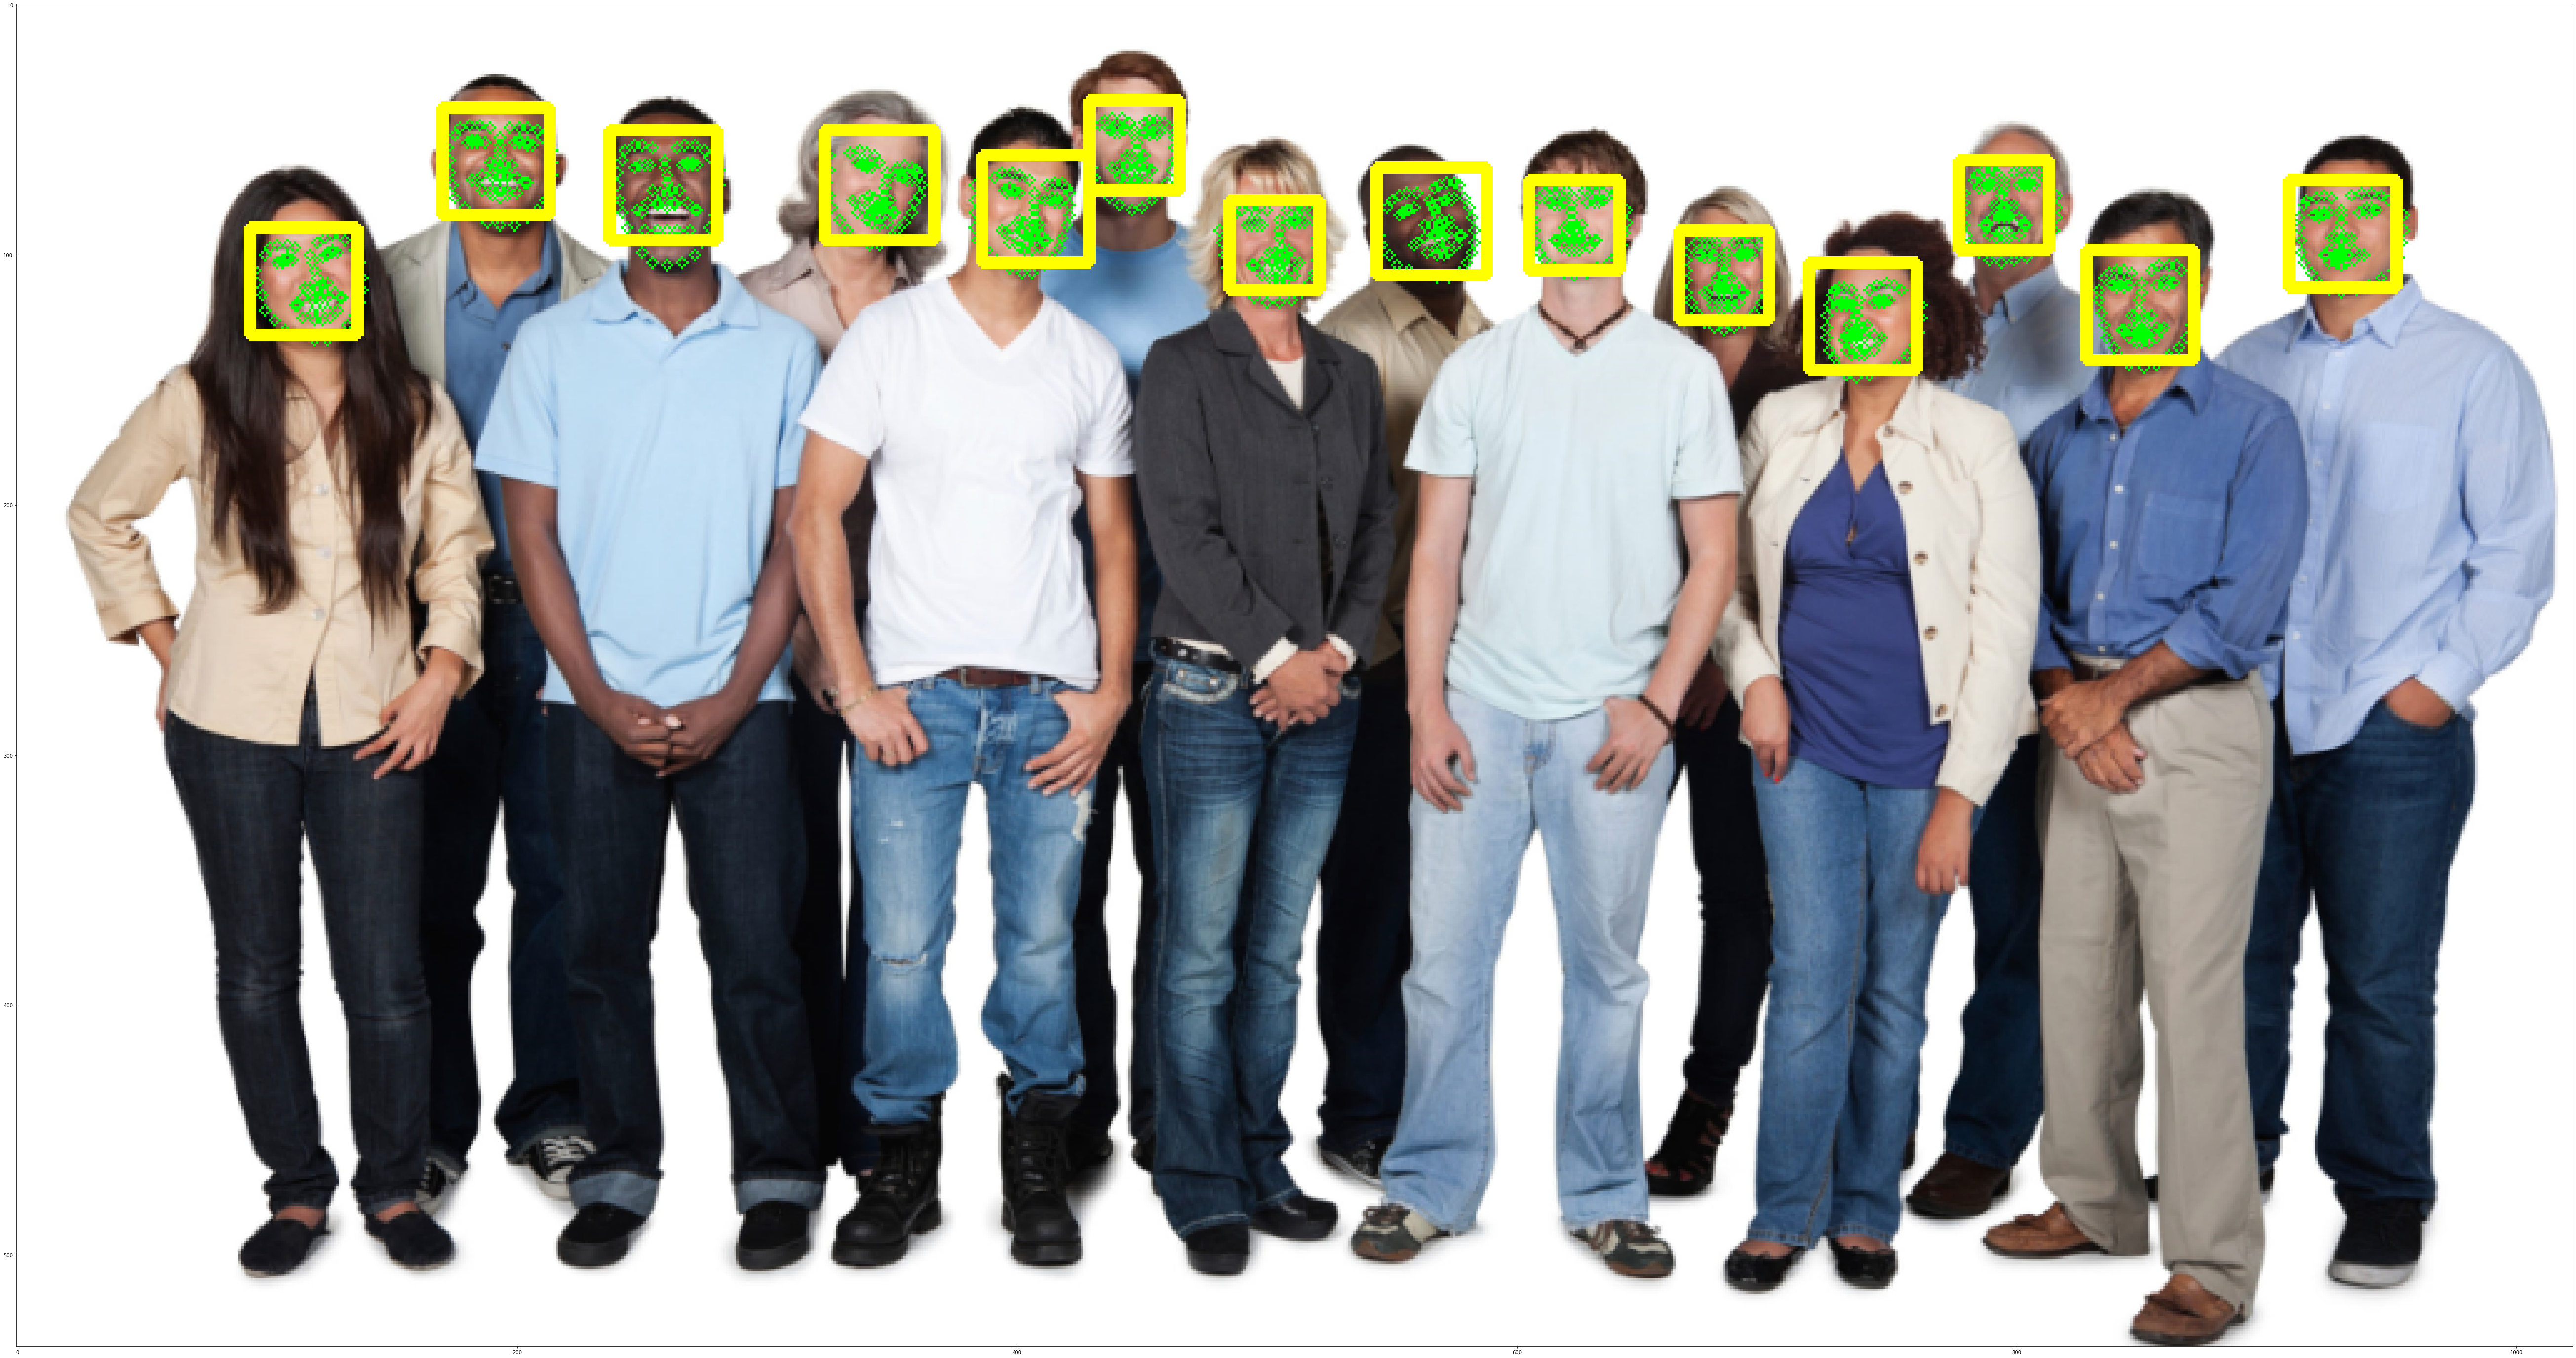

In [5]:
cvt_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for face in face_detection:
    
    for point in points_detector(image, face).parts():
        cv2.circle(cvt_image, (point.x, point.y), 2, (0, 255, 0), 1)
    
    pt1, pt2 = (face.left(), face.top()), (face.right(), face.bottom())
    cv2.rectangle(cvt_image, pt1, pt2, (255, 255, 0), 3)

plt.figure(figsize=(100,50))
plt.imshow(cvt_image)

### Detecting facial descriptor

얼굴 기술자 사용 : https://arxiv.org/abs/1512.03385

In [6]:
import os

In [7]:
image = cv2.imread('../../assets/Images/people2.jpg')

face_detector = dlib.get_frontal_face_detector()

face_descriptor_extractor = dlib.face_recognition_model_v1('../../assets/Weights/dlib_face_recognition_resnet_model_v1.dat')

points_detector = dlib.shape_predictor('../../assets/Weights/shape_predictor_68_face_landmarks.dat')

In [8]:
index = {}

idx = 0
face_descriptors = None

paths = [os.path.join('yalefaces/train', f) for f in os.listdir('yalefaces/train')]
paths = [f.replace('\\', '/') for f in paths]

for path in paths:
    
    image = Image.open(path).convert('RGB')
    image_np = np.array(image, 'uint8')
    
    face_detection = face_detector(image_np, 1)
    for face in face_detection:
        pt1, pt2 = (face.left(), face.top()), (face.right(), face.bottom())
        cv2.rectangle(image_np, pt1, pt2, (0, 0, 255), 2)
        
        # 언제나 68개의 포인트를 리턴합니다.
        points = points_detector(image_np, face)
        for point in points.parts():
            cv2.circle(image_np, (point.x, point.y), 2, (0, 255, 0), 1)
        
        
        face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points) # 언제나 128개의 결과를 리턴합니다.
        
        face_descriptor = [f for f in face_descriptor]                   # list가 아닌 구조를 list로 변환
        face_descriptor = np.asarray(face_descriptor, dtype=np.float64)  # list의 구조를 numpy array로 변환
        face_descriptor = face_descriptor[np.newaxis, :] # (128,)을 (1, 128)로 만드는 구문
        
        
        if face_descriptors is None:
            face_descriptors = face_descriptor
        else:
            face_descriptors = np.concatenate((face_descriptors, face_descriptor), axis = 0)
            
            
        index[idx] = path
        idx += 1

In [30]:
print(len(paths), face_descriptors.shape, index[0])

30 (132, 128) yalefaces/train/subject01.glasses.gif


### Calculating the distance between faces

numpy.linalg.norm 링크 : https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html

In [10]:
print(paths[131])
np.linalg.norm(face_descriptors[131] - face_descriptors[131])

yalefaces/train/subject15.normal.gif


0.0

In [11]:
def getCalc(tar_a, tar_b, paths, face_descriptors):
    res = np.linalg.norm(face_descriptors[tar_a] - face_descriptors[tar_b])
    print(f'{int(paths[tar_a].split("/")[2][7:9])}와 {int(paths[tar_b].split("/")[2][7:9])}의 차이 : ', res)

In [12]:
getCalc(8, 131, paths, face_descriptors)
getCalc(8, 130, paths, face_descriptors)
getCalc(131, 130, paths, face_descriptors)

1와 15의 차이 :  0.6862227114659764
1와 15의 차이 :  0.7103258684611107
15와 15의 차이 :  0.45545772058204587


In [13]:
np.argmin(
    np.linalg.norm(face_descriptors[131] - face_descriptors, axis = 1)
)

131

In [14]:
np.argmin(
    np.linalg.norm(face_descriptors[0] - face_descriptors, axis = 1)
)

0

### Detecting faces with Dlib

이 예제에서는 대상 이미지(확인하고자 하는 이미지)와 추정 이미지 항목들 간의 **거리**를 기준으로 판단합니다. <br>
따라서, 조절값인 threshold 또한 **거리**를 의미하며, **숫자가 낮을 수록 정확도가 높아집니다.**

- threshold가 0.2인 예제를 보면, 너무 높은 정확도를 요구하는 탓에 아무 것도 찾을 수 없었습니다.
- threshold가 0.5인 예제를 보면, 적당한 것 같습니다.

In [25]:
paths = [os.path.join('yalefaces/test', f) for f in os.listdir('yalefaces/test')]
paths = [f.replace('\\', '/') for f in paths]
print(paths[0])
print(paths[1])

yalefaces/test/subject01.gif
yalefaces/test/subject01.happy.gif


#### threhold = 0.2

예측값 Not identified 은  1 과 동일합니까? False
예측값 Not identified 은  1 과 동일합니까? False
예측값 Not identified 은  2 과 동일합니까? False
예측값 Not identified 은  2 과 동일합니까? False
예측값 Not identified 은  3 과 동일합니까? False
예측값 Not identified 은  3 과 동일합니까? False
예측값 Not identified 은  4 과 동일합니까? False
예측값 Not identified 은  4 과 동일합니까? False
예측값 Not identified 은  5 과 동일합니까? False
예측값 Not identified 은  5 과 동일합니까? False
예측값 Not identified 은  6 과 동일합니까? False
예측값 Not identified 은  6 과 동일합니까? False
예측값 Not identified 은  7 과 동일합니까? False
예측값 Not identified 은  7 과 동일합니까? False
예측값 Not identified 은  8 과 동일합니까? False
예측값 Not identified 은  8 과 동일합니까? False
예측값 Not identified 은  9 과 동일합니까? False
예측값 Not identified 은  9 과 동일합니까? False
예측값 Not identified 은  10 과 동일합니까? False
예측값 Not identified 은  10 과 동일합니까? False
예측값 Not identified 은  11 과 동일합니까? False
예측값 Not identified 은  11 과 동일합니까? False
예측값 Not identified 은  12 과 동일합니까? False
예측값 Not identified 은  12 과 동일합니까? False
예측값 Not identified 은  13 과 동일합니까? False
예측값 Not identified

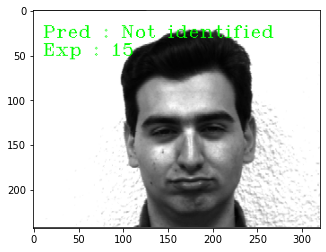

In [43]:
threshold = 0.2

for path in paths:
    image = Image.open(path).convert('RGB')
    image_np = np.array(image, 'uint8')
    
    face_detection = face_detector(image_np, 1)
    for face in face_detection:
        points = points_detector(image_np, face)
        face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
        
        face_descriptor = [f for f in face_descriptor]
        face_descriptor = np.asanyarray(face_descriptor, dtype=np.float64)
        face_descriptor = face_descriptor[np.newaxis, :]
        
        distances = np.linalg.norm(face_descriptor - face_descriptors, axis = 1)
        min_index = np.argmin(distances)
        min_distance = distances[min_index]
        
        if min_distance <= threshold:
            name_predictation = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject', ''))
        else:
            name_predictation = 'Not identified'
            
        name_real = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
        
        cv2.putText(image_np, 'Pred : ' + str(name_predictation), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
        cv2.putText(image_np, 'Exp : ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
    
    print('예측값', str(name_predictation), '은 ', str(name_real), '과 동일합니까?', name_predictation == name_real)
    plt.imshow(image_np)

#### threshold = 0.5

예측값 1 은  1 과 동일합니까? True
예측값 1 은  1 과 동일합니까? True
예측값 2 은  2 과 동일합니까? True
예측값 2 은  2 과 동일합니까? True
예측값 3 은  3 과 동일합니까? True
예측값 3 은  3 과 동일합니까? True
예측값 4 은  4 과 동일합니까? True
예측값 4 은  4 과 동일합니까? True
예측값 5 은  5 과 동일합니까? True
예측값 5 은  5 과 동일합니까? True
예측값 6 은  6 과 동일합니까? True
예측값 6 은  6 과 동일합니까? True
예측값 7 은  7 과 동일합니까? True
예측값 7 은  7 과 동일합니까? True
예측값 8 은  8 과 동일합니까? True
예측값 8 은  8 과 동일합니까? True
예측값 9 은  9 과 동일합니까? True
예측값 9 은  9 과 동일합니까? True
예측값 10 은  10 과 동일합니까? True
예측값 10 은  10 과 동일합니까? True
예측값 11 은  11 과 동일합니까? True
예측값 11 은  11 과 동일합니까? True
예측값 12 은  12 과 동일합니까? True
예측값 12 은  12 과 동일합니까? True
예측값 13 은  13 과 동일합니까? True
예측값 13 은  13 과 동일합니까? True
예측값 14 은  14 과 동일합니까? True
예측값 14 은  14 과 동일합니까? True
예측값 15 은  15 과 동일합니까? True
예측값 15 은  15 과 동일합니까? True


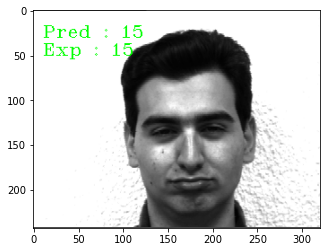

In [44]:
threshold = 0.5

for path in paths:
    image = Image.open(path).convert('RGB')
    image_np = np.array(image, 'uint8')
    
    face_detection = face_detector(image_np, 1)
    for face in face_detection:
        points = points_detector(image_np, face)
        face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
        
        face_descriptor = [f for f in face_descriptor]
        face_descriptor = np.asanyarray(face_descriptor, dtype=np.float64)
        face_descriptor = face_descriptor[np.newaxis, :]
        
        distances = np.linalg.norm(face_descriptor - face_descriptors, axis = 1)
        min_index = np.argmin(distances)
        min_distance = distances[min_index]
        
        if min_distance <= threshold:
            name_predictation = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject', ''))
        else:
            name_predictation = 'Not identified'
            
        name_real = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
        
        cv2.putText(image_np, 'Pred : ' + str(name_predictation), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
        cv2.putText(image_np, 'Exp : ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
    
    print('예측값', str(name_predictation), '은 ', str(name_real), '과 동일합니까?', name_predictation == name_real)
    plt.imshow(image_np)

### Tuning : Detecting faces with Dlib

앞서, 얼굴 감지를 구현하였고 이를 튜닝하여 더 정확도 높게 만드는 법을 배우겠습니다.

예측값 1 은  1 과 동일합니까? True
예측값 1 은  1 과 동일합니까? True
예측값 2 은  2 과 동일합니까? True
예측값 2 은  2 과 동일합니까? True
예측값 3 은  3 과 동일합니까? True
예측값 3 은  3 과 동일합니까? True
예측값 4 은  4 과 동일합니까? True
예측값 4 은  4 과 동일합니까? True
예측값 5 은  5 과 동일합니까? True
예측값 5 은  5 과 동일합니까? True
예측값 6 은  6 과 동일합니까? True
예측값 6 은  6 과 동일합니까? True
예측값 7 은  7 과 동일합니까? True
예측값 7 은  7 과 동일합니까? True
예측값 8 은  8 과 동일합니까? True
예측값 8 은  8 과 동일합니까? True
예측값 9 은  9 과 동일합니까? True
예측값 9 은  9 과 동일합니까? True
예측값 10 은  10 과 동일합니까? True
예측값 10 은  10 과 동일합니까? True
예측값 11 은  11 과 동일합니까? True
예측값 11 은  11 과 동일합니까? True
예측값 12 은  12 과 동일합니까? True
예측값 12 은  12 과 동일합니까? True
예측값 13 은  13 과 동일합니까? True
예측값 13 은  13 과 동일합니까? True
예측값 14 은  14 과 동일합니까? True
예측값 14 은  14 과 동일합니까? True
예측값 15 은  15 과 동일합니까? True
예측값 15 은  15 과 동일합니까? True


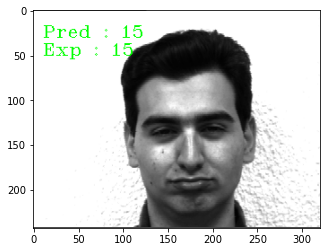

In [47]:
threshold = 0.5
predictions = []
expected_outputs = []

for path in paths:
    image = Image.open(path).convert('RGB')
    image_np = np.array(image, 'uint8')
    
    face_detection = face_detector(image_np, 1)
    for face in face_detection:
        points = points_detector(image_np, face)
        face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
        
        face_descriptor = [f for f in face_descriptor]
        face_descriptor = np.asanyarray(face_descriptor, dtype=np.float64)
        face_descriptor = face_descriptor[np.newaxis, :]
        
        distances = np.linalg.norm(face_descriptor - face_descriptors, axis = 1)
        min_index = np.argmin(distances)
        min_distance = distances[min_index]
        
        if min_distance <= threshold:
            name_predictation = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject', ''))
        else:
            name_predictation = 'Not identified'
            
        name_real = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
        
        predictions.append(name_predictation)
        expected_outputs.append(name_real)
        
        cv2.putText(image_np, 'Pred : ' + str(name_predictation), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
        cv2.putText(image_np, 'Exp : ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
    
    print('예측값', str(name_predictation), '은 ', str(name_real), '과 동일합니까?', name_predictation == name_real)
    plt.imshow(image_np)
    
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

In [48]:
print(predictions)
print(expected_outputs)

[ 1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12
 13 13 14 14 15 15]
[ 1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12
 13 13 14 14 15 15]


In [49]:
from sklearn.metrics import accuracy_score

In [50]:
accuracy_score(predictions, expected_outputs)

1.0